## Training autoencoder for anomaly detection using synthetic EEG signal dataset and K-means clustering

In [1]:
# Loading packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random as rn

from mpl_toolkits.mplot3d import Axes3D

from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

C:\Users\Tóth Mátyás\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Tóth Mátyás\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Tóth Mátyás\AppData\Local\Progr

## Generate synthetic EEG data based on real EEG signal

In [2]:
RANDOM_SEED = 140

In [3]:
eeg_data = loadmat('data/eeg21.mat')

In [4]:
eeg_data_python_list = [[i for i in j] for j in eeg_data['eeg']]

In [5]:
print(min(eeg_data_python_list))
print(max(eeg_data_python_list))

[-59.611099426552]
[56.506062091571]


In [6]:
real_eeg = np.array(eeg_data_python_list[0:150]).reshape(150*1)

In [7]:
synthetic_eeg_matrix_A = np.random.uniform(-75.65357, 50.90023,(2700, 150)) * real_eeg * 0.05
synthetic_eeg_matrix_B = np.random.uniform(-20.98769, 30.62023,(2300, 150)) * real_eeg * 0.08
synthetic_eeg_matrix = np.vstack((synthetic_eeg_matrix_A, synthetic_eeg_matrix_B))
np.random.shuffle(synthetic_eeg_matrix)

In [8]:
dataframe = pd.DataFrame(synthetic_eeg_matrix)

## Let us use K-means cluster to create the labels of normal and abnormal EEG signals in an unsupervised manner

In [9]:
kmeans = KMeans(n_clusters = 2)

In [10]:
kmeans.fit(dataframe)

C:\Users\Tóth Mátyás\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [11]:
dataframe[150] = kmeans.labels_

In [12]:
values = dataframe.values
normal = dataframe[dataframe[150] == 0]
abnormal = dataframe[dataframe[150] == 1]
datapoints = values[:, 0:-1]
labels = values[:,-1]

## Let us plot the data by using T-SNE to see how the data scatters in lower dimension

In [13]:
def tsne_scatter(features, labels, dimensions=2):

    # t-SNE dimensionality reduction:
    features_embedded = TSNE(n_components=dimensions, random_state = RANDOM_SEED).fit_transform(features)
    
    # initialising the plot:
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions

    # plotting data:
    ax.scatter(*zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='b',
        s=2,
        alpha=0.7,
        label='Normal')
                             
    ax.scatter(*zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.3,
        label='Abnormal')

    # storing it to be displayed later:
    plt.title('T-SNE visualization of normal and abnormal \n synthetic EEG signals', fontsize = 20)
    plt.legend(loc='best', fontsize = 16)
    plt.axis('off')
    plt.show

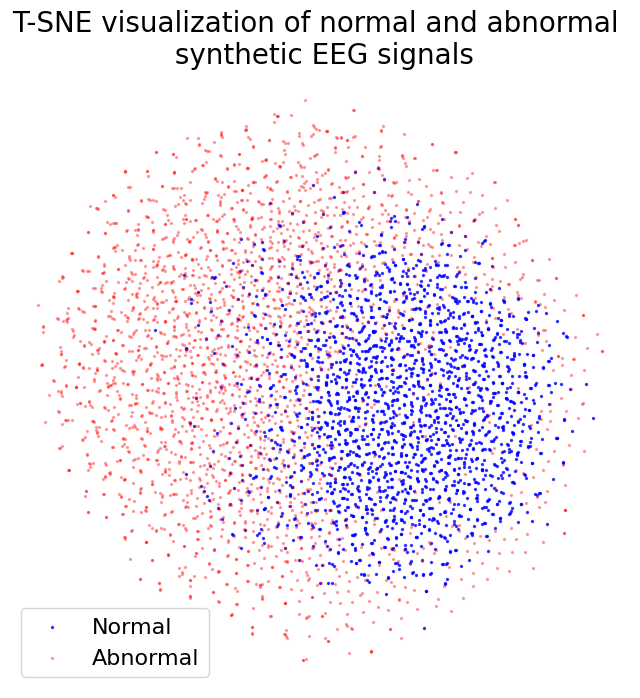

In [14]:
tsne_scatter(datapoints, labels, dimensions=2)

## Prepare the data for the autoencoder

In [15]:
# The last element contains the labels:

labels = values[:, -1]

# The other data points are the electrocadriogram data:

data = values[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)

In [16]:
# Precprocess data - by creating a lower level representation of our data we reduce the required computational power for runing the autoencoder:

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [17]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## Create the autoencoder

In [18]:
class AnomalyDetector(Model):
      def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])
    
        self.decoder = tf.keras.Sequential([
          layers.Dense(8, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(150, activation="tanh")])
    
      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [19]:
autoencoder.compile(optimizer='adam', loss='mae')

In [20]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=40, 
          batch_size=1024,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/40
2/2 [==============================] - 3s 359ms/step - loss: 0.4550 - val_loss: 0.4415
Epoch 2/40
2/2 [==============================] - 0s 90ms/step - loss: 0.4497 - val_loss: 0.4333
Epoch 3/40
2/2 [==============================] - 0s 61ms/step - loss: 0.4406 - val_loss: 0.4217
Epoch 4/40
2/2 [==============================] - 0s 86ms/step - loss: 0.4280 - val_loss: 0.4068
Epoch 5/40
2/2 [==============================] - 0s 70ms/step - loss: 0.4115 - val_loss: 0.3879
Epoch 6/40
2/2 [==============================] - 0s 70ms/step - loss: 0.3906 - val_loss: 0.3649
Epoch 7/40
2/2 [==============================] - 0s 84ms/step - loss: 0.3657 - val_loss: 0.3405
Epoch 8/40
2/2 [==============================] - 0s 78ms/step - loss: 0.3390 - val_loss: 0.3157
Epoch 9/40
2/2 [==============================] - 0s 47ms/step - loss: 0.3125 - val_loss: 0.2935
Epoch 10/40
2/2 [==============================] - 0s 48ms/step - loss: 0.2897 - val_loss: 0.2759
Epoch 11/40
2/2 [===========

## Let us plot some measurments of model performance:

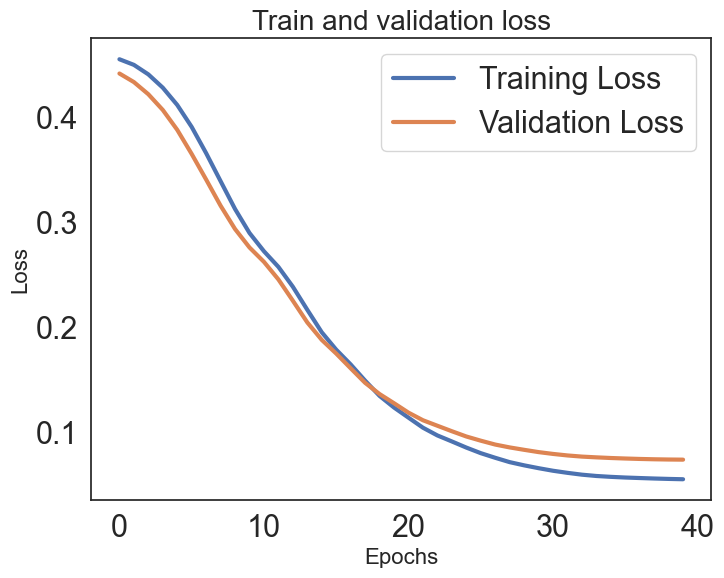

In [21]:
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Train and validation loss', fontsize = 20)
plt.legend()

In [22]:
encoded_sigs = autoencoder.encoder(normal_test_data).numpy()
decoded_sigs = autoencoder.decoder(encoded_sigs).numpy()

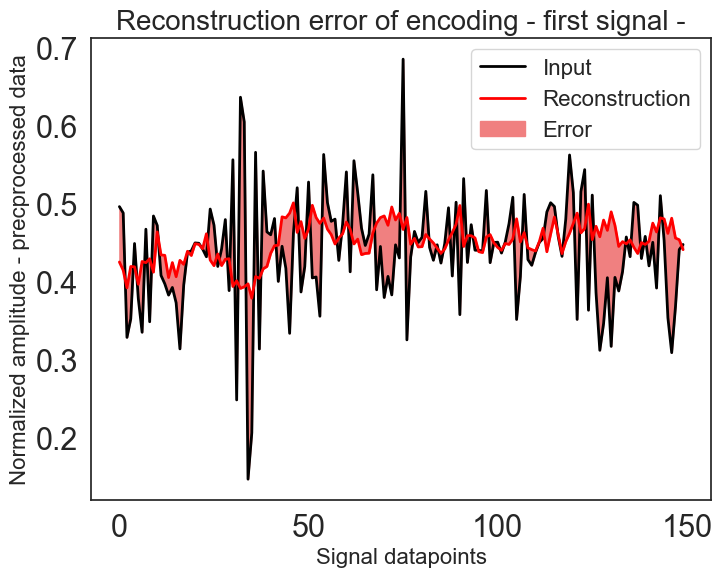

In [23]:
plt.figure(figsize=(8,6))
plt.plot(normal_test_data[0], 'black',linewidth=2)
plt.plot(decoded_sigs[0], 'red',linewidth=2)
plt.fill_between(np.arange(150), decoded_sigs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"], fontsize = 16)
plt.title('Reconstruction error of encoding - first signal -', fontsize = 20)
plt.xlabel('Signal datapoints', fontsize = 16)
plt.ylabel('Normalized amplitude - precprocessed data', fontsize = 16)
plt.show()

In [24]:
encoded_sigs_normal = pd.DataFrame(encoded_sigs)
encoded_sigs_normal[150] = 0

In [25]:
encoded_sigs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_sigs = autoencoder.decoder(encoded_sigs).numpy()

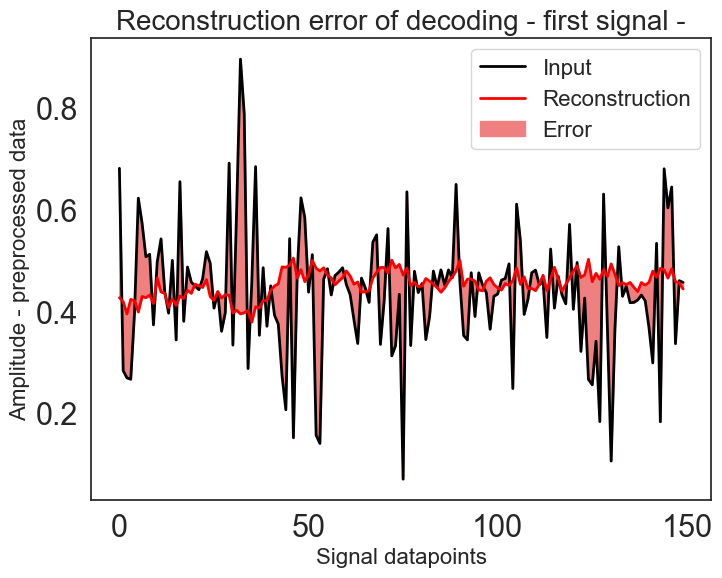

In [26]:
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(anomalous_test_data[0], 'black',linewidth=2)
plt.plot(decoded_sigs[0], 'red',linewidth=2)
plt.fill_between(np.arange(150), decoded_sigs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"], fontsize = 16)
plt.title('Reconstruction error of decoding - first signal -', fontsize = 20)
plt.xlabel('Signal datapoints', fontsize = 16)
plt.ylabel('Amplitude - preprocessed data', fontsize = 16)
plt.show()

In [27]:
encoded_sigs_abnormal = pd.DataFrame(encoded_sigs)
encoded_sigs_abnormal[150] = 1

In [28]:
all_encoded = pd.concat([encoded_sigs_normal,encoded_sigs_abnormal])

## Let us visualize the data manifold by using UMAP:

<AxesSubplot: >

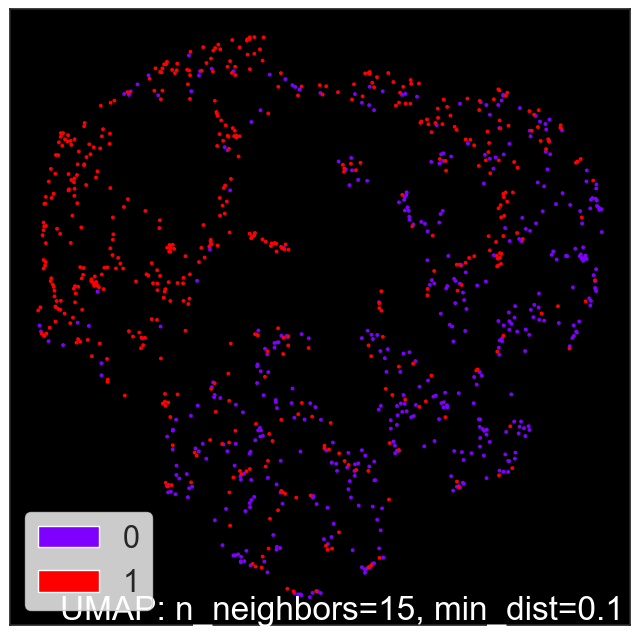

In [29]:
# Scatters:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire')

<AxesSubplot: >

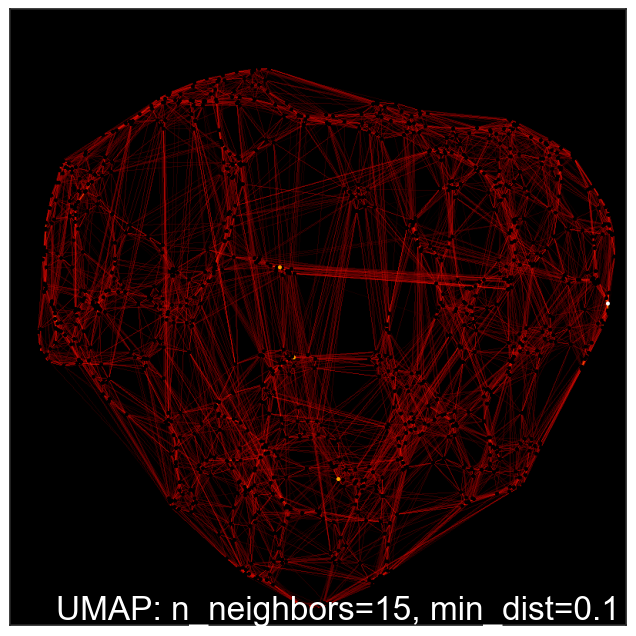

In [30]:
# Connectivity:
umap.plot.connectivity(mapper, show_points=True, theme = 'fire')

# Lets visualize the reconstruction loss distribtutions of normal and abnormal signals and the anomaly detection threshold
Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold.

In [31]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

59/59 [==============================] - 0s 2ms/step


In [32]:
np.mean(train_loss)

0.0552955

In [39]:
# lets set the threshold arbitrarly by adding the standard deviation to the average reconstruction training loss:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.06031785


In [40]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

17/17 [==============================] - 0s 1ms/step


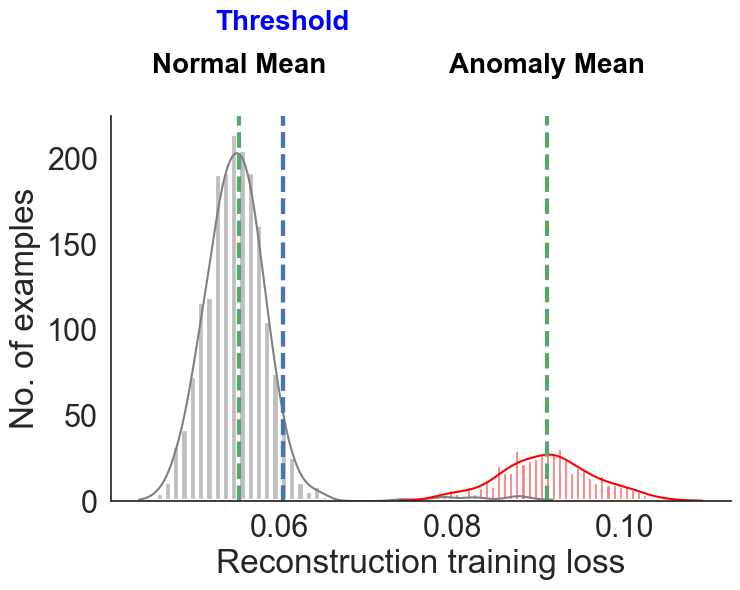

In [42]:
plt.figure(figsize=(8,5))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 250, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 275, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 250, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("Reconstruction training loss")
plt.ylabel("No. of examples")
sns.despine()

## Evaluate the model:

In [36]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [37]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.797
Precision = 1.0
Recall = 0.5690021231422505
